In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Setting gaya seaborn
sns.set(style="whitegrid")

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import os

import warnings
warnings.filterwarnings('ignore')


C:\Users\fatha\miniconda3\envs\my_env\lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.stats import gaussian_kde


In [9]:
# Path ke dataset
dataset_path = "C:/Users/fatha/Downloads/aivsreal_imagesv2"

# Path untuk setiap kategori
real_path = os.path.join(dataset_path, "Human")
ai_path = os.path.join(dataset_path, "AI")

# Mendapatkan daftar file
real_images = os.listdir(real_path)
ai_images = os.listdir(ai_path)

print(f"Jumlah gambar Human: {len(real_images)}")
print(f"Jumlah gambar AI: {len(ai_images)}")

Jumlah gambar Human: 1523
Jumlah gambar AI: 1729


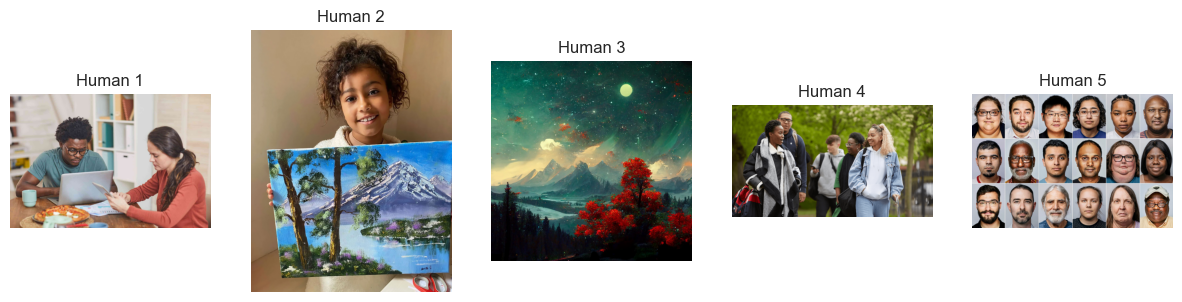

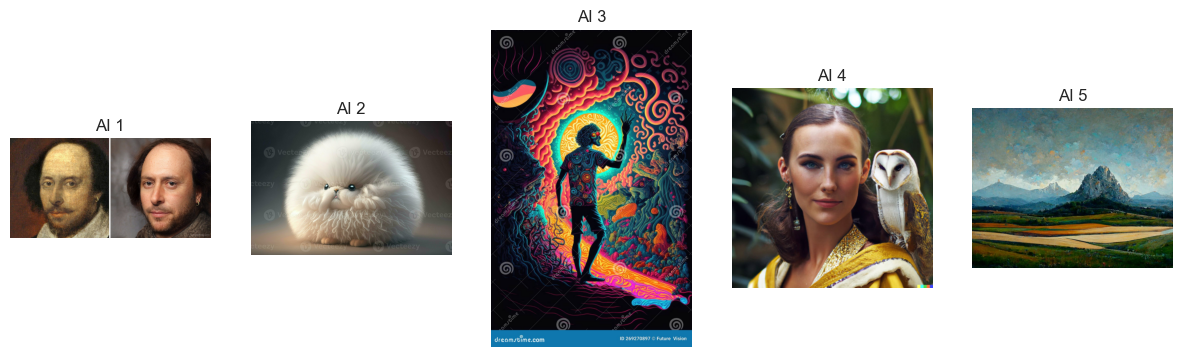

In [10]:
def display_images(images, title, path, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = Image.open(os.path.join(path, images[i]))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

# Menampilkan contoh gambar asli
display_images(real_images, "Human", real_path)

# Menampilkan contoh gambar AI
display_images(ai_images, "AI", ai_path)

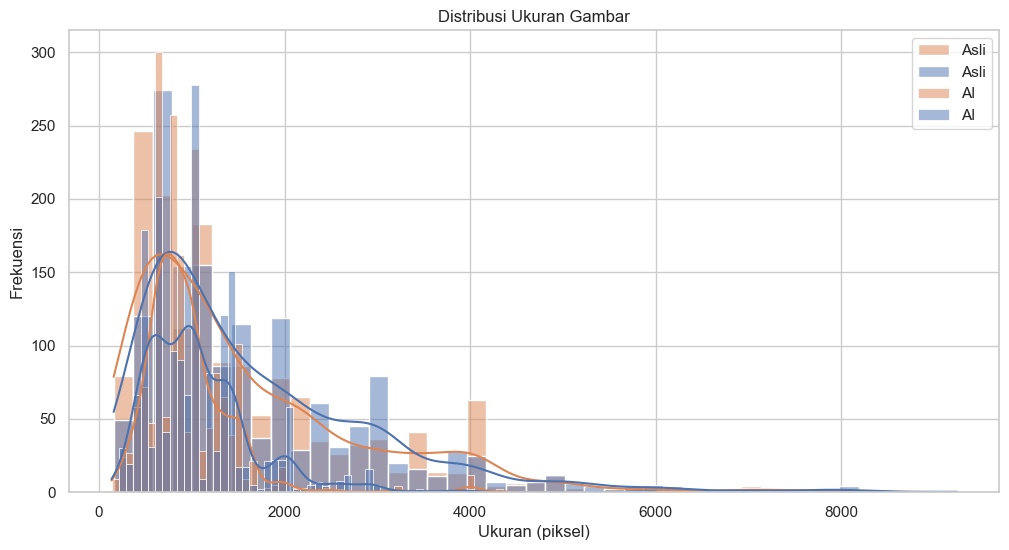

In [11]:
def get_image_sizes(images, path):
    sizes = []
    for img_name in images:
        img = Image.open(os.path.join(path, img_name))
        sizes.append(img.size)
    return sizes

# Mendapatkan ukuran gambar
real_sizes = get_image_sizes(real_images, real_path)
ai_sizes = get_image_sizes(ai_images, ai_path)

# Membuat DataFrame untuk visualisasi
import pandas as pd

real_df = pd.DataFrame(real_sizes, columns=["Width", "Height"])
ai_df = pd.DataFrame(ai_sizes, columns=["Width", "Height"])

# Visualisasi distribusi ukuran gambar
plt.figure(figsize=(12, 6))
sns.histplot(real_df, kde=True, color="blue", label="Asli")
sns.histplot(ai_df, kde=True, color="red", label="AI")
plt.title("Distribusi Ukuran Gambar")
plt.xlabel("Ukuran (piksel)")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

In [12]:
# Statistik deskriptif untuk gambar asli
print("Statistik deskriptif untuk gambar asli:")
real_df.describe()

Statistik deskriptif untuk gambar asli:


Width       Height
count  1523.000000  1523.000000
mean   1681.366382  1579.596192
std    1299.790685  1289.387419
min     183.000000   158.000000
25%     693.500000   640.000000
50%    1240.000000  1131.000000
75%    2319.000000  2160.000000
max    9248.000000  8598.000000

In [13]:
# Statistik deskriptif untuk gambar AI
print("Statistik deskriptif untuk gambar AI:")
ai_df.describe()

Statistik deskriptif untuk gambar AI:


Width       Height
count  1729.000000  1729.000000
mean   1079.790052   953.759977
std     600.400827   482.614140
min     225.000000   135.000000
25%     640.000000   640.000000
50%    1024.000000   880.000000
75%    1344.000000  1080.000000
max    6000.000000  4320.000000

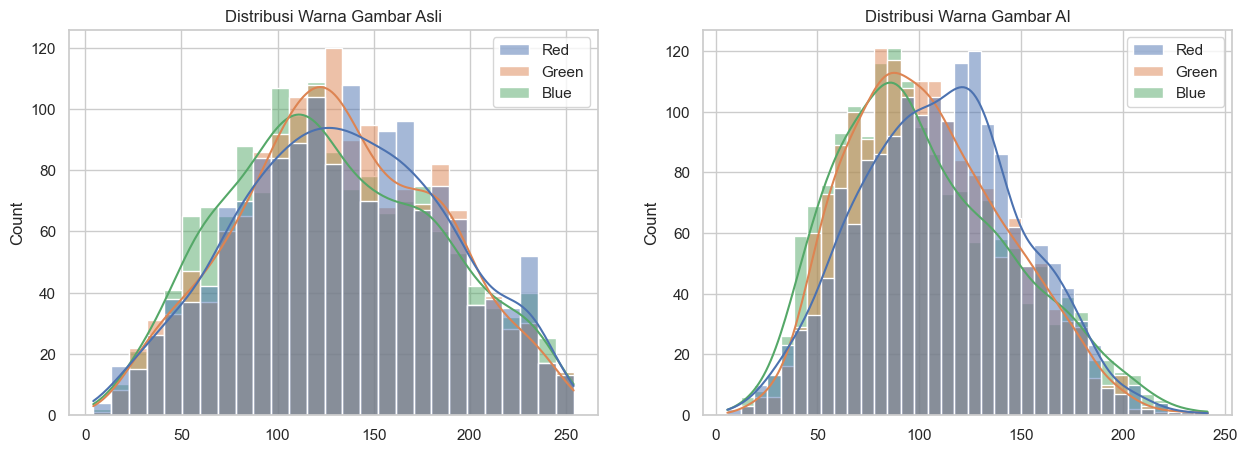

In [14]:
def get_average_color(image_path):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    avg_color = img_np.mean(axis=(0, 1))
    return avg_color

real_colors = [get_average_color(os.path.join(real_path, img)) for img in real_images]
ai_colors = [get_average_color(os.path.join(ai_path, img)) for img in ai_images]

# Membuat DataFrame untuk warna
real_colors_df = pd.DataFrame(real_colors, columns=["Red", "Green", "Blue"])
ai_colors_df = pd.DataFrame(ai_colors, columns=["Red", "Green", "Blue"])

# Visualisasi distribusi warna
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(real_colors_df, kde=True)
plt.title("Distribusi Warna Gambar Asli")

plt.subplot(1, 2, 2)
sns.histplot(ai_colors_df, kde=True)
plt.title("Distribusi Warna Gambar AI")

plt.show()

In [15]:
BASE_DIR = dataset_path

training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = training_datagen.flow_from_directory(BASE_DIR,
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',
                                                       subset='training')

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(BASE_DIR,
                                                              target_size=(224, 224),
                                                              batch_size=32,
                                                              class_mode='binary',
                                                              subset='validation')

x,y = next(train_generator)
x.shape

Found 2597 images belonging to 2 classes.
Found 649 images belonging to 2 classes.


(32, 224, 224, 3)

In [18]:
# Fungsi untuk menampilkan beberapa gambar dari setiap kelas
def display_samples(generator, class_names, samples_per_class=5):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class * 3, len(class_names) * 3))
    for i, class_name in enumerate(class_names):
        class_index = generator.class_indices[class_name]
        class_count = 0
        for x_batch, y_batch in generator:
            for j in range(len(y_batch)):
                if y_batch[j] == class_index:
                    axes[i, class_count].imshow(x_batch[j])
                    axes[i, class_count].axis('off')
                    axes[i, class_count].set_title(class_name)
                    class_count += 1
                    if class_count == samples_per_class:
                        break
            if class_count == samples_per_class:
                break
    plt.show()

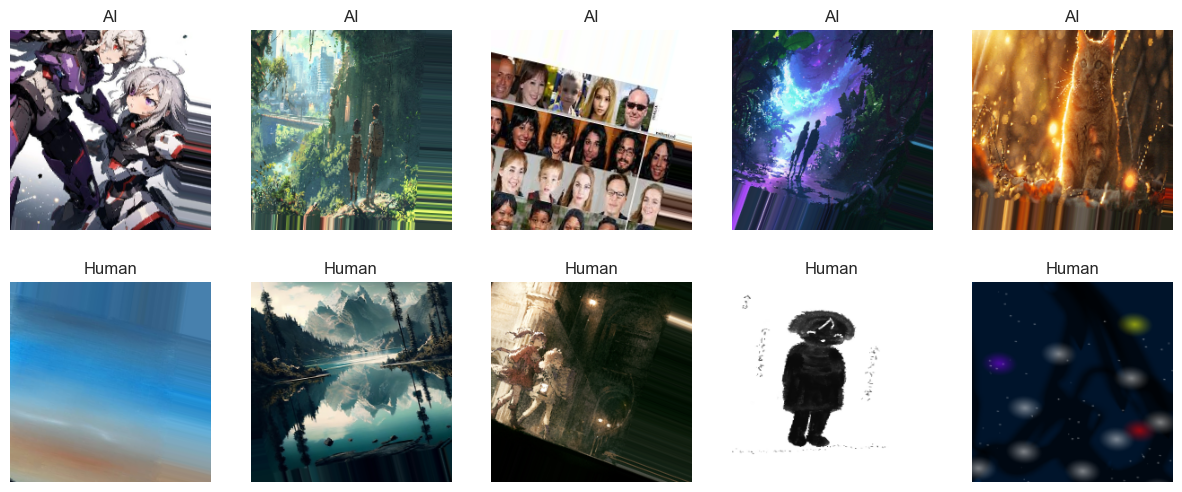

In [19]:
# Mendapatkan nama kelas dari train_generator
class_names = list(train_generator.class_indices.keys())

# Menampilkan beberapa sampel dari setiap kelas
display_samples(train_generator, class_names, samples_per_class=5)

In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                        

In [21]:
tf.keras.utils.plot_model(model, show_dtype=True,
                       show_layer_names=True, show_shapes=True,
                       to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    shuffle=True
)

Epoch 1/50
81/81 [==============================] - 161s 2s/step - loss: 0.7957 - accuracy: 0.6051 - val_loss: 1.2690 - val_accuracy: 0.4688
Epoch 2/50
81/81 [==============================] - 143s 2s/step - loss: 0.7029 - accuracy: 0.6253 - val_loss: 1.1726 - val_accuracy: 0.4641
Epoch 3/50
81/81 [==============================] - 146s 2s/step - loss: 0.6684 - accuracy: 0.6522 - val_loss: 0.9911 - val_accuracy: 0.4672
Epoch 4/50
81/81 [==============================] - 143s 2s/step - loss: 0.6414 - accuracy: 0.6565 - val_loss: 0.8188 - val_accuracy: 0.4875
Epoch 5/50
81/81 [==============================] - 143s 2s/step - loss: 0.5965 - accuracy: 0.7010 - val_loss: 1.1327 - val_accuracy: 0.5016
Epoch 6/50
81/81 [==============================] - 145s 2s/step - loss: 0.5893 - accuracy: 0.6932 - val_loss: 0.5826 - val_accuracy: 0.7125
Epoch 7/50
81/81 [==============================] - 145s 2s/step - loss: 0.5722 - accuracy: 0.7010 - val_loss: 0.6071 - val_accuracy: 0.6844
Epoch 8/50
81

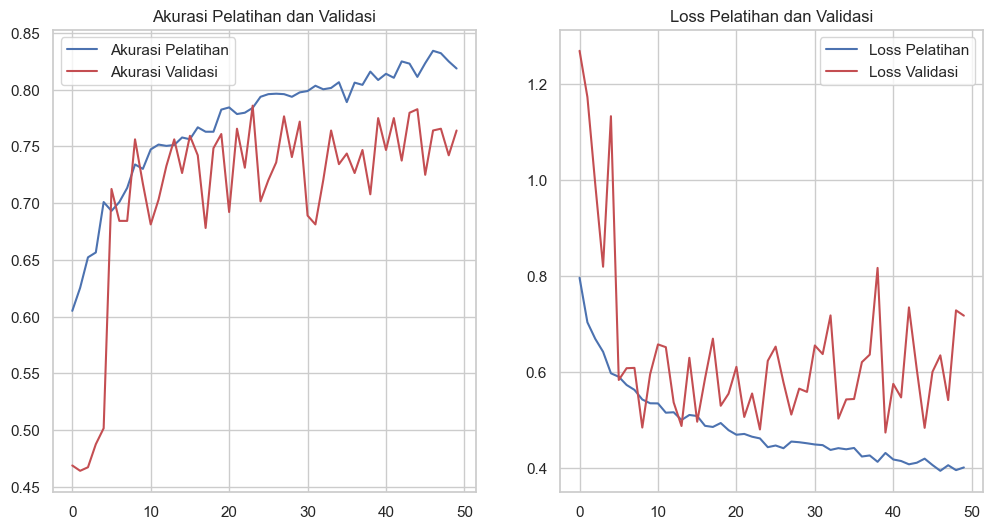

In [23]:
import matplotlib.pyplot as plt

# Mendapatkan nilai akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Akurasi Pelatihan')
plt.plot(epochs, val_acc, 'r', label='Akurasi Validasi')
plt.title('Akurasi Pelatihan dan Validasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Loss Pelatihan')
plt.plot(epochs, val_loss, 'r', label='Loss Validasi')
plt.title('Loss Pelatihan dan Validasi')
plt.legend()

plt.show()

21/21 [==============================] - 31s 1s/step


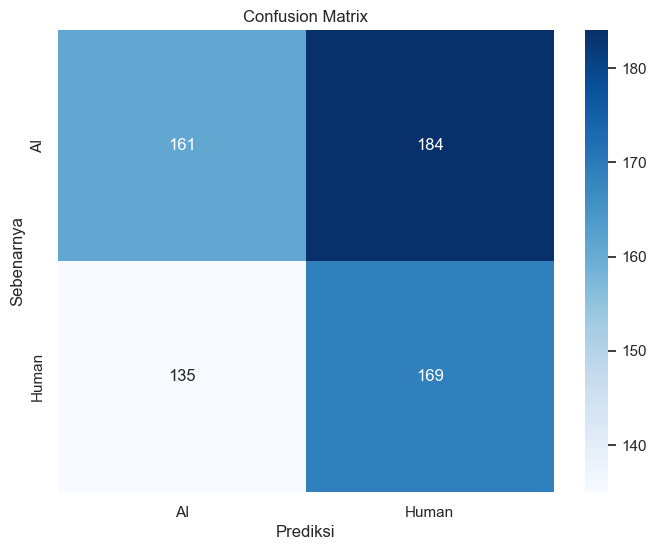

              precision    recall  f1-score   support

          AI       0.54      0.47      0.50       345
       Human       0.48      0.56      0.51       304

    accuracy                           0.51       649
   macro avg       0.51      0.51      0.51       649
weighted avg       0.51      0.51      0.51       649



In [28]:
# Prediksi label validasi
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.where(Y_pred > 0.5, 1, 0)

# Mendapatkan label sebenarnya
y_true = validation_generator.classes

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 [==============================] - 1s 676ms/step


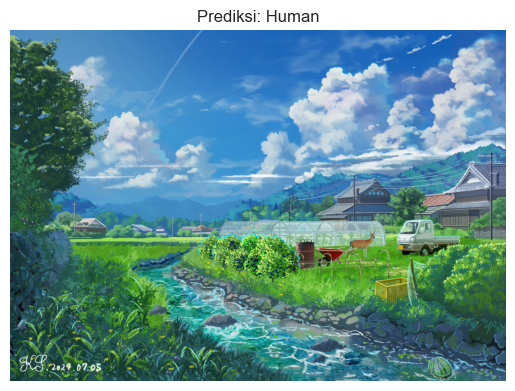

1/1 [==============================] - 0s 25ms/step


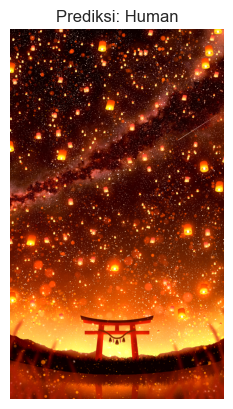

1/1 [==============================] - 0s 24ms/step


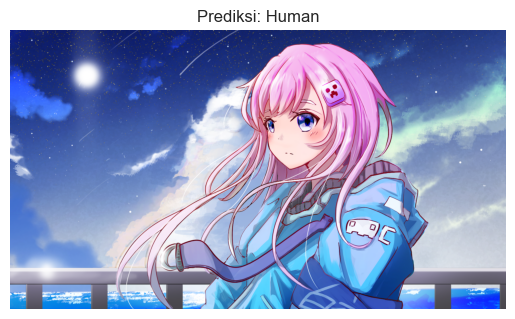

1/1 [==============================] - 0s 26ms/step


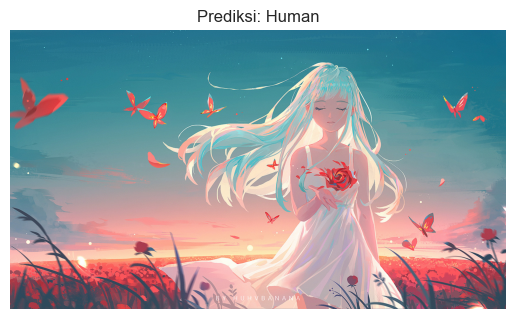

1/1 [==============================] - 0s 28ms/step


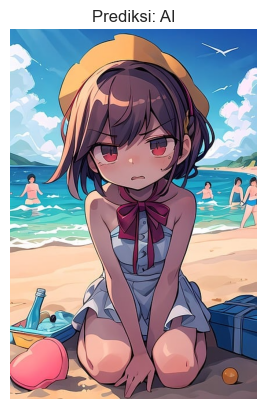

1/1 [==============================] - 0s 22ms/step


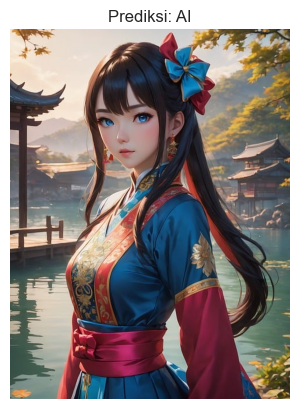

1/1 [==============================] - 0s 26ms/step


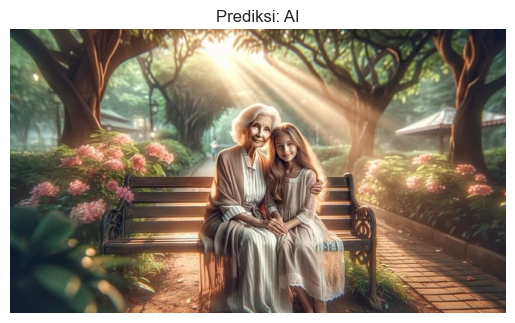

1/1 [==============================] - 0s 27ms/step


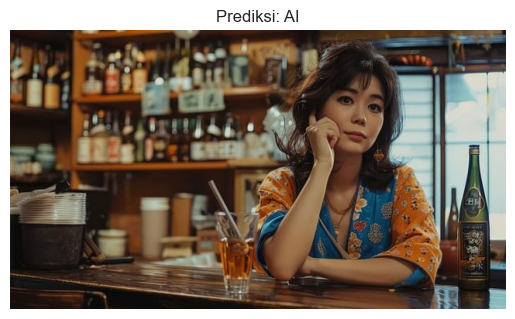

1/1 [==============================] - 0s 29ms/step


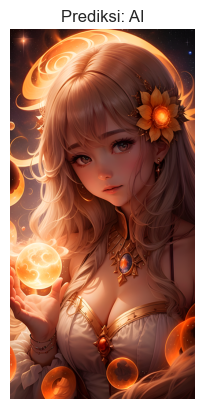

1/1 [==============================] - 0s 27ms/step


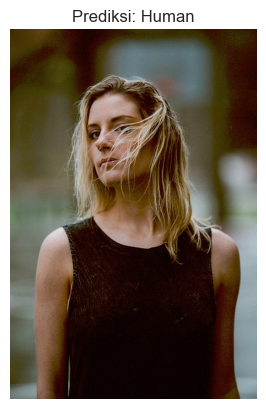

In [30]:
from tensorflow.keras.preprocessing import image

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Path ke folder gambar untuk prediksi
predict_folder = "C:/Users/fatha/Downloads/test"

# Mendapatkan daftar file gambar
image_files = [f for f in os.listdir(predict_folder) if f.endswith(('jpg', 'png', 'jpeg'))]

# Memproses dan memprediksi setiap gambar
for img_file in image_files:
    img_path = os.path.join(predict_folder, img_file)
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = class_names[int(np.round(prediction)[0][0])]
    
    # Tampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class}")
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 115ms/step


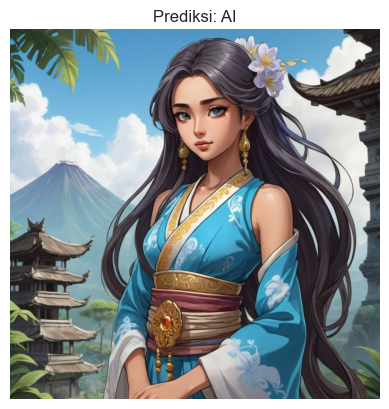

In [4]:
from tensorflow.keras.preprocessing import image
# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

model = load_model("C:/Users/fatha/Downloads/model_ai_vs_real.h5")

class_names = ["AI", "Human"]
# Path ke gambar untuk prediksi
img_path = "C:/Users/fatha/Downloads/aiiiiiiii.jpg"

# Memuat dan memproses gambar
img_array = load_and_preprocess_image(img_path)

# Lakukan prediksi
prediction = model.predict(img_array)
predicted_class = class_names[int(np.round(prediction)[0][0])]

# Tampilkan gambar dan hasil prediksi
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Prediksi: {predicted_class}")
plt.axis('off')
plt.show()


In [37]:
model.save('C:/Users/fatha/Downloads/models/model_ai_vs_real.h5')